<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Classifier


***
### Contributors



### Introduction



In [1]:
#Import packages

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# import from qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, compile
from qiskit.converters import qobj_to_circuits
from qiskit import Aer, IBMQ
from qiskit.providers.aer import noise

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram        
from qiskit.tools.qi.qi import state_fidelity, outer
from qiskit.tools.qi.qi import outer
from qiskit.quantum_info import state_fidelity
from qiskit.tools.monitor import job_monitor, backend_overview
from qiskit.providers.ibmq import least_busy

C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
Aer.backends() # No need for credentials for running the next cells

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

### Circuit of FIG. 6

In [3]:
# Determine the job
n = 3 #simplified

# create a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
my_state = QuantumCircuit(qr, cr, name='my_state')
a0 = 0
m0 = 1
i0 = 2

theta = 2.152 # for x~''
#theta = 1.518 # for x~'

#A        
my_state.h(qr[a0])
my_state.h(qr[m0])
#B
#my_state.cx(qr[a0],qr[i0])
my_state.cu3(2*theta,0,0,qr[a0],qr[i0])
#my_state.cx(qr[a0],qr[i0])
#my_state.ry(theta,qr[i0])
my_state.x(qr[a0])
#C
my_state.ccx(qr[a0],qr[m0],qr[i0])
my_state.x(qr[m0])
#D
my_state.ccx(qr[a0],qr[m0],qr[i0])
my_state.cx(qr[m0],qr[i0])
my_state.ry(0.331,qr[i0])
my_state.cx(qr[m0],qr[i0])
my_state.ry(-0.331,qr[i0])
my_state.ccx(qr[a0],qr[m0],qr[i0])
my_state.cx(qr[m0],qr[i0])
my_state.ry(-0.331,qr[i0])
my_state.cx(qr[m0],qr[i0])
my_state.ry(0.331,qr[i0])
#E
#my_state.swap(qr[i0],qr[c0]) # with swap
#my_state.cx(qr[m0],qr[i0]) # with swap
#my_state.cx(qr[m0],qr[c0]) # without swap
#F
my_state.h(qr[a0])

# Measurement circuit
measuring = QuantumCircuit(qr, cr, name='measuring')
measuring.measure(qr[a0] , cr[a0])
#measuring.measure(qr[i0] , cr[i0]) # with swap
#measuring.measure(qr[c0] , cr[c0]) # without swap
measuring.measure(qr[m0] , cr[m0]) #simplified
test = my_state+measuring

### Test the algorithm using a noise free simulation

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

Date (DMY): 02/02/2019 21:35:35
{'011': 1849, '000': 3799, '001': 315, '010': 2229}


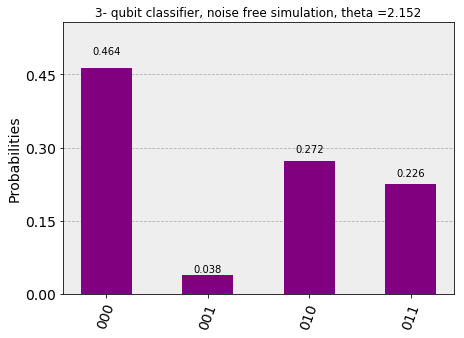

In [4]:
# Test circuit "my_state" : Noise free model on simulator
backend_sim = Aer.get_backend('qasm_simulator')
shots = 8192
job_noisefree = execute(test, backend_sim, shots=shots, max_credits=5)
job_monitor(job_noisefree)

noisefree_count = job_noisefree.result().get_counts(test)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print(noisefree_count)
plot_histogram(noisefree_count, color=['purple'], 
               title=str(n) + '- qubit classifier, noise free simulation, theta =' +str(theta) )

In [5]:
# QASM from test
QASM_source = test.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[3];
creg c0[3];
h q0[0];
h q0[1];
cu3(4.30400000000000,0,0) q0[0],q0[2];
x q0[0];
ccx q0[0],q0[1],q0[2];
x q0[1];
ccx q0[0],q0[1],q0[2];
cx q0[1],q0[2];
ry(0.331000000000000) q0[2];
cx q0[1],q0[2];
ry(-0.331000000000000) q0[2];
ccx q0[0],q0[1],q0[2];
cx q0[1],q0[2];
ry(-0.331000000000000) q0[2];
cx q0[1],q0[2];
ry(0.331000000000000) q0[2];
h q0[0];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];



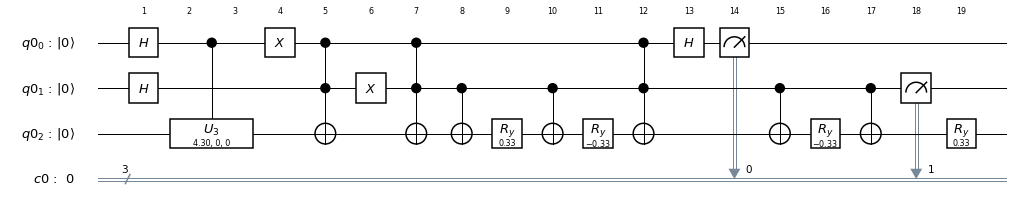

In [6]:
# Draw the circuit
my_style = {'latexdrawerstyle': False, 'cregbundle': True, 'fold': 30, 'showindex': True}
test.draw(output='mpl', style=my_style)

### State tomography and quantum fidelity in noise free device simulation

In [7]:
# Execute state tomography using noise free quantum device simulation

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

backend_tomo = Aer.get_backend('qasm_simulator') # for simulation

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024
mode = "noise free simulation"
my_state_job = execute(my_state_tomo_circuits, backend_tomo, shots=shots)
job_monitor(my_state_job)
my_state_tomo_result = my_state_job.result()    
        
# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit classifier on', backend_tomo,
      ", shots:", shots, ", mode:", mode, "theta:", theta)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

Date (DMY): 02/02/2019 21:36:34
Tomography 3-qubit classifier on qasm_simulator , shots: 1024 , mode: noise free simulation theta: 2.152
Fidelity with theoretical ideal state
F = 0.9922355276220067


### From here, you need credentials:

In [8]:
IBMQ.load_accounts()

In [9]:
backend_overview() # you may skip running this cell if you want

ibmq_16_melbourne           ibmqx4
-----------------           ------
Num. Qubits:  14            Num. Qubits:  5
Pending Jobs: 2             Pending Jobs: 3
Least busy:   True          Least busy:   False
Operational:  True          Operational:  True
Avg. T1:      52.8          Avg. T1:      52.3
Avg. T2:      66.6          Avg. T2:      18.5





In [13]:
backend_real = least_busy(IBMQ.backends(operational=True, simulator=False))
backen_real = 'ibmqx4' # forcing ibmqx4
print(backend_real)

ibmqx4


### Prepare noise simulation corresponding to a given quantum device

In [14]:
# Prepare device noise simulation (DNS)

device = backend_real
print("device: ", device)
properties = device.properties()
coupling_map = device.configuration().coupling_map
prepared = False
if device.name() == 'ibmq_16_melbourne' :
    gate_times = [
        ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
        ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
        ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
        ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
        ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
        ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
        ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
    ]
    prepared = True
    
elif device.name() == 'ibmqx4' :
    gate_times = [
        ('u1', None, 0), ('u2', None, 60), ('u3', None, 120),
        ('cx', [1, 0], 340), ('cx', [2, 0], 424), ('cx', [2, 1], 520),
        ('cx', [3, 2], 620), ('cx', [3, 4], 420), ('cx', [4, 2], 920)    
    ]
    prepared = True

else :
    print("No gate times yet defined in this notebook for: ", device)
        
if prepared :
    # Construct the noise model from backend properties and custom gate times
    noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)

    # Get the basis gates for the noise model
    basis_gates = noise_model.basis_gates
    
    print("noise model prepared for", device)


device:  ibmqx4
noise model prepared for ibmqx4


### Run the algorithm using device noise simulation (DNS)

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

<bound method AerJob.status of <qiskit.providers.aer.aerjob.AerJob object at 0x0000013167361400>>
Date (DMY): 02/02/2019 21:38:55
{'011': 252, '000': 347, '001': 150, '010': 275}


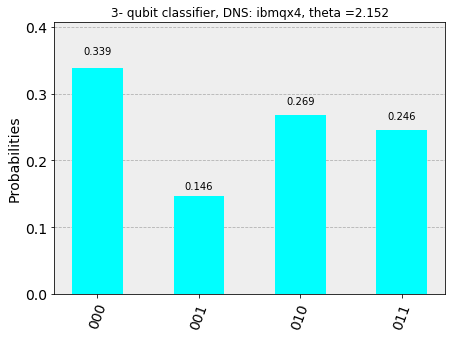

In [15]:
# Execute test using device noise simulation (DNS)

backend_noise = Aer.get_backend('qasm_simulator') # for simulation (DNS)

shots = 1024
mode = "DNS"
job_noise = execute(test, backend_noise, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
job_monitor(job_noise)

print(job_noise.status)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
noisy_count = job_noise.result().get_counts(test) 
print(noisy_count)
plot_histogram(noisy_count, color=['cyan'],
               title= str(n) + '- qubit classifier, ' + mode + ': {}, '.format(device.name()) + "theta =" +str(theta))

### State tomography and quantum fidelity in device noise simulation (DNS)

In [16]:
# Execute state tomography using device noise simulation (DNS)

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)
my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.    

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

backend_tomo = Aer.get_backend('qasm_simulator') # for simulation

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024
mode = "DNS"
my_state_job = execute(my_state_tomo_circuits, backend_tomo, 
                               noise_model=noise_model,
                               coupling_map=coupling_map,
                               basis_gates=basis_gates)
job_monitor(my_state_job)
my_state_tomo_result = my_state_job.result()    

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit classifier on', backend_tomo,
      ", shots:", shots, ", mode:", mode, "of", device, "theta:", theta)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is actively running </p>")

Date (DMY): 02/02/2019 21:40:54
Tomography 3-qubit classifier on qasm_simulator , shots: 1024 , mode: DNS of ibmqx4 theta: 2.152
Fidelity with theoretical ideal state
F = 0.47270741477672734


### Run the algorithm on superconducting quantum computing device (SQC)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

<bound method IBMQJob.status of <qiskit.providers.ibmq.ibmqjob.IBMQJob object at 0x000001316754CEB8>>
{'011': 215, '000': 358, '001': 230, '010': 221}


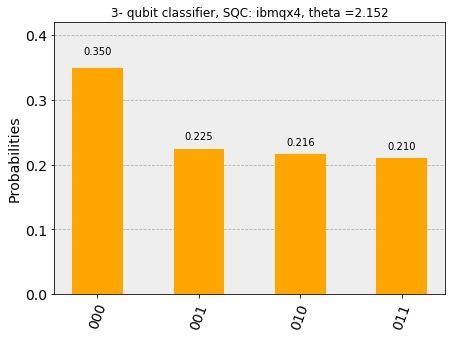

In [17]:
# Execute test using superconducting quantum computing device (SQC)

#Choose the backend
#backend_noise = Aer.get_backend('qasm_simulator') # for optional test before final experiment 
backend_noise = device # for least busy SQC device

# Execute on SQC and get counts
shots = 1024
if backend_noise.name() == "qasm_simulator" : # optional test before final experiment 
    mode = "DNS"
    job_noise = execute(test, backend_noise, 
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates)
else: # final experiment on real device
    mode = "SQC"
    job_noise = execute(test, backend_noise)
    job_monitor(job_noise)

print(job_noise.status)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
noisy_count = job_noise.result().get_counts(test) 
print(noisy_count)
plot_histogram(noisy_count, color=['orange'], 
               title= str(n) + '- qubit classifier, ' + mode + ': {}, '.format(device.name()) + "theta =" +str(theta))

### State tomography and quantum fidelity on superconducting quantum computing device (SQC)

In [17]:
# Execute state tomography on superconducting quantum computing device (SQC)

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

#Choose the backend
#backend_tomo = Aer.get_backend('qasm_simulator') # optional test before final experiment
backend_tomo = device # for least busy SQC device

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024

# loop: 27 circuits maximum per job to avoid exceeding the allowed limit for the real device.  
n_circ = 3**n
i_max = min(27,n_circ)
my_jobs = []
index_job = -1
for i in range(0,n_circ,i_max) :
    circs =[]
    for j in range(i, i+i_max):
        circs.append(my_state_tomo_circuits[j])
    if backend_tomo.name() == "qasm_simulator" : # optional test before final experiment
        mode = "DNS"
        my_state_job = execute(circs, backend_tomo, 
                               noise_model=noise_model,
                               coupling_map=coupling_map,
                               basis_gates=basis_gates)
    else: # final experiment on real device
        mode = "SQC" 
        my_state_job = execute(circs, backend_tomo, shots=shots)
    my_jobs.append(my_state_job)
    index_job = index_job + 1 
    job_monitor(my_jobs[index_job], monitor_async = True)
    
    my_state_new_result = my_state_job.result()
    if i == 0:
        my_state_tomo_result = my_state_new_result
    else:
        my_state_tomo_result = my_state_tomo_result +  my_state_new_result

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit classifier on', backend_tomo,
      ", shots:", shots, ", method:", method, ", mode:", mode, device, "theta:", theta)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\qiskit\result\result.py:267: DeprecationWarning: Result addition is deprecated and will be removed in version 0.7+.
  'version 0.7+.', DeprecationWarning)
C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\qiskit\result\result.py:245: DeprecationWarning: Result addition is deprecated and will be removed in version 0.7+.
  'version 0.7+.', DeprecationWarning)


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\qiskit\result\result.py:267: DeprecationWarning: Result addition is deprecated and will be removed in version 0.7+.
  'version 0.7+.', DeprecationWarning)
C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\qiskit\result\result.py:245: DeprecationWarning: Result addition is deprecated and will be removed in version 0.7+.
  'version 0.7+.', DeprecationWarning)


Date (DMY): 01/02/2019 19:16:32


NameError: name 'method' is not defined

In [18]:
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit classifier on', backend_tomo,
      ", shots:", shots,  ", mode:", mode, device, "theta:", theta)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

Date (DMY): 01/02/2019 19:16:32
Tomography 4-qubit classifier on ibmqx4 , shots: 1024 , mode: SQC ibmqx4 theta: 2.152
Fidelity with theoretical ideal state
F = 0.17073221336518524


### Comparing DNS to SQC
The results mentioned above for the DNS and SQC experiments are illustrated together in the next graphs:

Herafter a comparison of the histograms of estimated outcome probabilities obtained during noise-free simulation, DNS and SQC experiments on ibmqx4 using Qiskit 0.7.

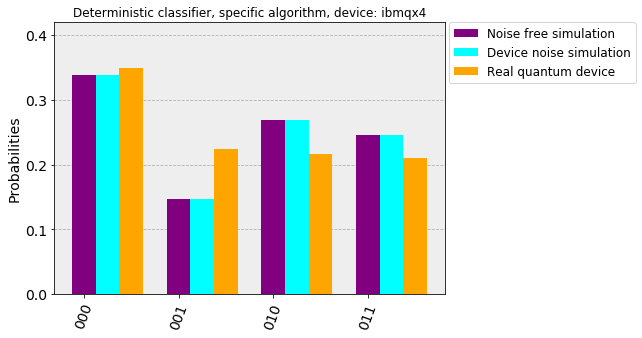

In [18]:
# DSN vs SQC, count histograms
# Shots = 1024
count_noisefree = {'011': 252, '000': 347, '001': 150, '010': 275}
count_DNS = {'011': 252, '000': 347, '001': 150, '010': 275}
count_real = {'011': 215, '000': 358, '001': 230, '010': 221}
plot_histogram([count_noisefree, count_DNS, count_real], 
               title= 'Deterministic classifier, specific algorithm, device: ibmqx4', 
               color=['purple','cyan', 'orange'], bar_labels=False,
               legend = ['Noise free simulation', 'Device noise simulation','Real quantum device']) 

Hereafter a comparison of the quantum fidelity estimated by state tomography for device noise simulation (DSN) and real device (SQC), using either the specific algorithm or arbitrary  initialization:

### Concluding remarks:



### References:

[1] 

[2] 

[3] Smolin, J. A., Gambetta, J. M. & Smith, G. (2012). Efficient method for computing the maximum-likelihood quantum state from measurements with additive gaussian noise. Phys. Rev. Lett 108(7). https://link.aps.org/doi/10.1103/PhysRevLett.108.070502